In [2]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from typing import Dict, Text
import random
from collections import Counter

Welcome to the week 1 project of the Personalized Recommendations at Scale course! In this week's project, we’ll look at one key component of multi-stage recommender system -- the candidate generator. As you can probably guess from the name, multi-stage recommender systems consist of multiple stages. To walk through how these systems work, let’s focus on a typical large scale recommendation system. The process starts with candidate generation, when the recommendation system takes a large corpus of content and cuts it down to a sample recommendation palette. The model for this stage optimizes for recall, because if there’s an option the user might like, we want it to be identified here. The goal of candidate generation is to cut down the number of content options from millions to hundreds.

The candidates generated in this phase are then passed to the ranking phase. In the ranking phase, the recommendations are ranked based on how appropriate they are for the user. This stage often involves feeding additional information to the system, like user history and content features. It might also incorporate other candidates' sources, such as new content or time-specific recommendations. The best k-ranked are then returned and used to populate the recommendation list. A visualization of this process looks like is shown below:


![multi-stage system](https://miro.medium.com/max/1400/1*6LG9QN2XEtK6UCOZG4cavA.png)

With this background, let's dive deep into the candidate generator topic!

# Candidate Generation

When trying to recommend items to a user, we typically start with a huge catalog of options! As a result, our first step prior to ranking our recommendations is to generate a selection of candidates. In particular, we’ll use a mixture of various sources to pool a large catalog of millions of items to pick a smaller subset of options from. A heavy ranker cannot deal with and rank tens of millions of items due to latency requirements. A candidate generator comes in to help select a smaller pool of candidate items from a larger pool of millions of items which the ranker can then rank. As such, such candidate generators are often referred to as “light ranker”. An important property of the candidate generator is to fetch a sufficiently representative set of candidate items for the ranker to score – this means that the candidate generator is often evaluated on recall, and not precision. Precision of the selected candidates becomes ranker’s responsibility, and the candidate generator simply has to ensure it is selecting a representative set of candidate items the user might be interested in, and thus recall as an evaluation measure becomes an important metric for evaluating CGs.

In this week's project, we work on H&M's fashion recommendation dataset, and implement a few candidate generators and evaluate their performance on recall metric.

# **H&M Personalized Fashion Recommendations**

In this dataset, we are given the purchase history of customers across time, along with supporting metadata. The high level recommendation task is to predict what articles each customer will purchase in the test period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.

**articles.csv** - detailed metadata for each article_id available for purchase

**customers.csv** - metadata for each customer_id in dataset

**sample_submission.csv** - a sample submission file in the correct format

**transactions_train.csv** - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

We will first load the datasets, and perform exploratory data analysis to better understand the dataset we are dealing with, before diving further into the candidate generators.

Download the dataset hmdata.zip from https://drive.google.com/drive/folders/10LGZMgXRuz2qPr_QDbYdVVlKEcnQ25YL?usp=sharing

In [4]:
article_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hmdata/articles.csv.zip")
customer_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hmdata/customers.csv.zip")
train0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hmdata/transactions_train.csv.zip')
transaction_df = train0

# **Exploratory Data Analysis**

In [5]:

# f, ax = plt.subplots(figsize=(15, 7))
# ax = sns.histplot(data=article_df, y='index_name', color='blue')
# ax.set_xlabel('count by index name')
# ax.set_ylabel('index name')
# plt.show()

In [6]:
# f, ax = plt.subplots(figsize=(15, 7))
# ax = sns.histplot(data=article_df, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
# ax.set_xlabel('count by garment group')
# ax.set_ylabel('garment group')
# plt.show()

In [7]:
# sns.set_style("darkgrid")
# f, ax = plt.subplots(figsize=(10,5))
# ax = sns.histplot(data=customer_df, x='age', bins=50, color='green')
# ax.set_xlabel('Distribution of the customers age')
# plt.show()

In [8]:
# articles_for_merge = article_df[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]
# articles_for_merge = transaction_df[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

# sns.set_style("darkgrid")
# f, ax = plt.subplots(figsize=(25,18))
# ax = sns.boxplot(data=articles_for_merge, x='price', y='product_group_name')
# ax.set_xlabel('Price outliers', fontsize=22)
# ax.set_ylabel('Index names', fontsize=22)
# ax.xaxis.set_tick_params(labelsize=22)
# ax.yaxis.set_tick_params(labelsize=22)

# plt.show()

# **Simple Feature Processing**

Having looked at some initial analysis, we next perform simple feature processing for customer and article dataframes.

In [9]:
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]

customer_df["FN"].fillna(0, inplace=True)
customer_df["Active"].fillna(0, inplace=True)

# Set unknown the club member status & news frequency
customer_df["club_member_status"].fillna("UNKNOWN", inplace=True)

customer_df["fashion_news_frequency"] = customer_df["fashion_news_frequency"].replace({"None":"NONE"})
customer_df["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)

# Set missing values in age with the median
customer_df["age"].fillna(customer_df["age"].median(), inplace=True)
customer_df["age_interval"] = customer_df["age"].apply(lambda x: create_age_interval(x))

customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_interval
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[46, 55]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[16, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[16, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[46, 55]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[46, 55]"


In [10]:
# Replace missing values
article_df.fillna(value="No Description", inplace=True)

# Adjust the article ID and product code to be string & add "0"
#article_df["product_code"] = article_df["article_id"].apply(lambda x: x[:3])

#article_df.head()

In [11]:
article_df['article_id'] = article_df['article_id'].astype(str)
article_df['article_id'] = article_df['article_id'].apply(lambda x: x.zfill(10))

unique_customer_ids = customer_df.customer_id.unique()
unique_article_ids = article_df.article_id.unique()

article_ds = tf.data.Dataset.from_tensor_slices(dict(article_df[['article_id']]))
articles = article_ds.map(lambda x: x['article_id'])

We subselect 1 years worth of data to use for all the exercises this week.

In [12]:
train0 = train0[train0['t_dat'] <='2019-09-20']

# add 0 in article_id column (string)
train0['article_id'] = train0['article_id'].astype(str)
train0['article_id'] = train0['article_id'].apply(lambda x: x.zfill(10))
train0.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


Having selected this dataset, lets get to work. We will begin by describing the key metric we will use to evaluate the candidate generators, and then move on to discuss few candidate generator techniques. Finally, we will finish the project by comparing the recall metrics across the three candidate generators

# Key metric for candidate generation: _recall@k_

The goal of the candidate generator is to fetch enough reevant candidates for the ranker to rank. Indeed, the ranker works on top of the output of the candidate generator -- if the candidate generator fetches relevant candidates, the ranker can do a better job at ranking these candidates. However, if the candidate generator misses out on a large set of relevant items, the ranker cannot rank them since it doesn't have access to good candidate items.

Given such a role of the candidate generator, recall becomes the key metric with which we evaluate different candidate generators. Intuitively, *Recall* = of all relevant items, how many made it into the selected list?

_Recall@k_ is the proportion of relevant items found in the top-k selected candidates.

Mathematically recall@k is defined as follows:

_Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)_

Suppose we have a user who will make 5 purchases next month, and we wish to make 10 recommendations to this user on the homepage from among the set of 1 million products. Further suppose we have two candidate generators (CG-A and CG-B), each returning 100 candidates that the ranker can consumer and select the 10 recommendations. If CG-A is able to retrieve 3 of these 5 products amongst its set of 100 candidates, and CG-B is able to retrieve only 2 of the 5 products amongst its set of 100 candidates, then CG-A would have a higher recall than CG-B.
Recall for CG-A = 3/5
Recall for CG-B = 2/5


Lets implement this recall metric in a simple function and try it out.

In [13]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
def estimateRecall(cg, purchase):
    return len(intersection(cg,purchase))/len(purchase)

In [14]:
purchases = ["item45","item97","item71","item125","item5"]
cg1 = ["item1","item97","item12","item105","item5","item17","item197","item122","item85","item15"]
cg2 = ["item13","item94","item14","item15","item5","item18","item197","item132","item86","item65"]
print("recall for cg1: ",estimateRecall(cg1,purchases))
print("recall for cg1: ",estimateRecall(cg2,purchases))

recall for cg1:  0.4
recall for cg1:  0.2


# **Traditional Candidate Generation**

With the metric in place, now lets look into a few obvious candiate generators.

> **1. Candidate Genertator 1: random products**
The simplest candidate generator to start with is a random candidate selector -- from amongst the list of products, randomly select few products.


> **2. Candidate Genertator 2: Top most popular products**
Another simple candidate selection strategy is to select the top-k most popular products from historic interactions and use this list as the set of candidates for the downstream ranking goal.


> **3. Candidate Genertator 3: Two-tower model CG**
One of most popular, and industry-wide used CGs is a two-tower neural network. This is a learnt deep model with one tower for the user and another tower for the product, followed by a dot product. We describe this model in detail further down the notebook.


Below we will implement each of these three candidate generators and compare their performace in terms of recall metric.

In order to have a clean evaluation set-up, we will divide the transactions data we have into train and test split. We look at one year's of purchases and use the first 9 months as training data and the remaining three months as the test data.

In [28]:
train = train0[train0['t_dat']<='2019-06-20']
test = train0[train0['t_dat'] >'2019-06-20']

For ease of evaluation, without any loss of generalization, we only consider customers that have made a purchase in both train and test time-periods. The methods and set-up remain the same for all other customers as well.

In [53]:
c1 = train['customer_id'].to_list()
c2 = test['customer_id'].to_list()
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

commonUsers = intersection(c1, c2)

print(len(train),len(test),len(c1),len(c2),len(commonUsers))

12241294 4594115 12241294 4594115 418847


Here commonUsers represent the set of users for whom we would be interested in generating candidates.

In [17]:
#Candidate Generator 1: random products
    
def getKCandidatesRandom(u,k):
    return random.sample(train['article_id'].to_list(),k)

In [18]:
#Candidate Generator 2: top-k popular products based on historic interactions

def getTopKCandidatesPopular(u,k):
    c = Counter(train['article_id'].to_list())
    topPopular = [article for article, count in c.most_common(k)]
    return topPopular


In [30]:
# with the 2 CGs defined, we can now query these CGs for a set of users,
# and compute the recall metrics to see how well they perform.

def runCandidateGeneration(method,k):
    overallRecall = 0
    recallList = []
    i=0
    userSet = commonUsers[0:10]
    for u in userSet:
        purchaseList = test[test['customer_id']==u]['article_id'].to_list()
        cg = method(u,k)
        r = estimateRecall(cg,purchaseList)
        overallRecall+=r
        recallList.append(r)
    overallRecall = overallRecall/len(userSet)
    return (overallRecall,recallList)

In [54]:
# Running metric calculations for the CG 1: random CG, to fetch 100 and 1000 candidates.
r, rlist = runCandidateGeneration(getKCandidatesRandom,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(getKCandidatesRandom,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

recall for candidate generation at k=100 candidates fetched:  0.026666666666666665
recall for candidate generation at k=1000 candidates fetched:  0.06080808080808081


In [55]:
# Running metric calculations for CG 2: top popular products CG, to fetch 100 and 1000 candidates.

r, rlist = runCandidateGeneration(getTopKCandidatesPopular,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(getTopKCandidatesPopular,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

recall for candidate generation at k=100 candidates fetched:  0.02
recall for candidate generation at k=1000 candidates fetched:  0.18374176548089588


We notice that the recall@k metric is significantly higher for popular CG than for random CG, which is as per our expectations.

Both these CGs are non-learnt, and generic across all users. We now switch to discuss a learnt CG model -- the two-tower model which we covered in the Monday lecture.

# **Two Tower Model: Candidate Generator**

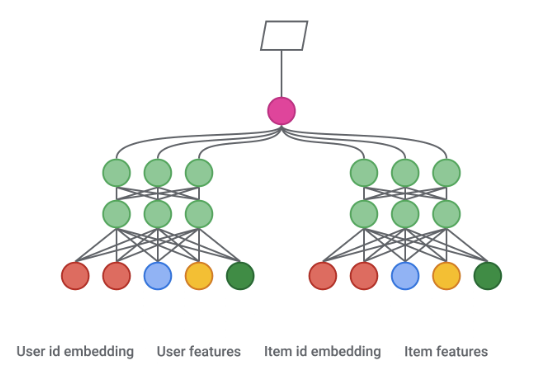

A two tower model is a neural network that is made up of two separate sub-models, one that learns representations for the users, and one that learns representations for candidate objects. This information is then combined in a single layer to produce a prediction of whether a user will like an item. This is currently one of the best-performing models for candidate generation, as it learns information from both the user and the items. Above, you can see a  visualization of how this process works.

This approach is useful for candidate generation across a wide variety of industries, from online retail to social media! With one tower representing the users and the other representing the items, the system can learn a lot about whether a user might like a particular item. These models are trained using implicit signals – YouTube, for example, might consider how many seconds a user streamed a video, or how they interacted with it. The learned information can then be combined to produce the final prediction.

In [21]:
embedding_dimension = 64

customer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_customer_ids, mask_token=None),  
  tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dimension),
  tf.keras.layers.Dense(64, activation='relu')
])


In [22]:
article_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_article_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dimension),
  tf.keras.layers.Dense(64, activation='relu')
])

### **Metric: FactorizedTopK**
To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the tfrs.metrics.FactorizedTopK metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

 The default metric is top K categorical accuracy: how often the true candidate is in the top K candidates for a given query.

In [23]:
class HandMModel(tfrs.Model):
    
    def __init__(self, customer_model, article_model):
        super().__init__()
        self.article_model: tf.keras.Model = article_model
        self.customer_model: tf.keras.Model = customer_model
        self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.article_model),            
            ),
        )        

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
    
        customer_embeddings = self.customer_model(features["customer_id"])    
        article_embeddings = self.article_model(features["article_id"])

        # The task computes the loss and the metrics.
        return self.task(customer_embeddings, article_embeddings,compute_metrics=not training)

TFRS exposes a base model class (tfrs.models.Model) which streamlines bulding models: all we need to do is to set up the components in the __init__ method, and implement the compute_loss method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.


The tfrs.Model base class is a simply convenience class: it allows us to compute both training and test losses using the same method.

Under the hood, it's still a plain Keras model. You could achieve the same functionality by inheriting from tf.keras.Model and overriding the train_step and test_step functions (see the guide for details):

In [24]:
class NoBaseClassHandMModel(tf.keras.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Set up a gradient tape to record gradients.
    with tf.GradientTape() as tape:

      # Loss computation.
      customer_embeddings = self.customer_model(features["customer_id"])
      positive_article_embeddings = self.article_model(features["article_id"])
      loss = self.task(customer_embeddings, positive_article_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    customer_embeddings = self.customer_model(features["user_id"])
    positive_article_embeddings = self.article_model(features["movie_title"])
    loss = self.task(customer_embeddings, positive_article_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [25]:
model = HandMModel(customer_model, article_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Then lets shuffle, batch, and cache the training and evaluation data, and train the model on the training data.


In [26]:

train_ds = tf.data.Dataset.from_tensor_slices(dict(train[['customer_id','article_id']])).shuffle(100_000).batch(256).cache()
test_ds = tf.data.Dataset.from_tensor_slices(dict(test[['customer_id','article_id']])).batch(256).cache()

num_epochs = 4

history = model.fit(train_ds,epochs=num_epochs, verbose=1)

Epoch 1/4
26121/26121 [==============================] - 284s 11ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1222.3475 - regularization_loss: 0.0000e+00 - total_loss: 1222.3475
Epoch 2/4
26121/26121 [==============================] - 170s 7ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 978.6687 - regularization_loss: 0.0000e+00 - total_loss: 978.6687
Epoch 3/4
26121/26121 [==============================] - 168s 6ms/step - factorized_top_k/top_1_categorical_accuracy: 0

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

Finally, we can evaluate our model on the test set:

In [27]:
test_ds = tf.data.Dataset.from_tensor_slices(dict(test.sample(2000)[['customer_id','article_id']])).batch(500).cache()
model.evaluate(test_ds, return_dict=True)


4/4 [==============================] - 25s 6s/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0075 - factorized_top_k/top_50_categorical_accuracy: 0.0185 - factorized_top_k/top_100_categorical_accuracy: 0.0280 - loss: 3739.6901 - regularization_loss: 0.0000e+00 - total_loss: 3739.6901


{'factorized_top_k/top_100_categorical_accuracy': 0.02800000086426735,
 'factorized_top_k/top_10_categorical_accuracy': 0.007499999832361937,
 'factorized_top_k/top_1_categorical_accuracy': 0.0005000000237487257,
 'factorized_top_k/top_50_categorical_accuracy': 0.01850000023841858,
 'factorized_top_k/top_5_categorical_accuracy': 0.004999999888241291,
 'loss': 3743.706298828125,
 'regularization_loss': 0,
 'total_loss': 3743.706298828125}

### **Making predictions**
Now that we have a model, we would like to be able to make predictions. We can use the tfrs.layers.factorized_top_k.BruteForce layer to do this.

In [28]:
articles = article_ds.map(lambda x: x['article_id'])

# Create a model that takes in raw customer features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.customer_model,k=50)
# recommends articles out of the entire dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((articles.batch(1000), articles.batch(1000).map(model.article_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657"]))
print(f"Recommendations for customer: {titles[0, :100]}")

Recommendations for customer: [b'0589840001' b'0537085001' b'0510278002' b'0634426005' b'0599580004'
 b'0703796001' b'0664074041' b'0593808001' b'0506191005' b'0688537011'
 b'0684209013' b'0691855005' b'0600043001' b'0713755001' b'0775107001'
 b'0610216002' b'0744304001' b'0757896001' b'0733801001' b'0837368001'
 b'0721598001' b'0744304002' b'0687061002' b'0696122001' b'0658298001'
 b'0681373013' b'0745232001' b'0708724003' b'0776427001' b'0757264005'
 b'0600044009' b'0638811002' b'0749421002' b'0585130003' b'0665849001'
 b'0600043011' b'0722681005' b'0665724001' b'0636902001' b'0582244001'
 b'0600044002' b'0762796001' b'0316553027' b'0734215002' b'0668390001'
 b'0490113016' b'0539723013' b'0745232002' b'0735843004' b'0696390003']


Now that we have the ability to make predictions, we would like to use this model and fetch the top-k candidates for the set of customers we have used for the previous two candidate generators.

Similar to the CG1 and CG2 functions, we define the two-tower CG function that takes in a customer ID and value k, and returns the list of top-k products as the list of candidate products.

In [29]:
def getTopKCandidates2Tower(u,k):
    # Create a model that takes in raw customer features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.customer_model,k)
    # recommends articles out of the entire dataset.
    index.index_from_dataset(
        tf.data.Dataset.zip((articles.batch(1000), articles.batch(1000).map(model.article_model)))
    )
    _, candidates = index(tf.constant([u]))
    candidates = candidates.numpy().tolist()[0]
    cg = []
    for c in candidates:
        cg.append(c.decode("utf-8") )
    return (cg)

We can now use this function to estimate the recall metrics for this new CG, and compare with the other 2 CGs we implemented before.

In [30]:
r, rlist = runCandidateGeneration(getTopKCandidates2Tower,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)
r, rlist = runCandidateGeneration(getTopKCandidates2Tower,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

recall for candidate generation at k=100 candidates fetched:  0.05588235294117647
recall for candidate generation at k=1000 candidates fetched:  0.11862745098039215


Now lets compile the results from the three different Candidate Generators we implemented:

**Recall at 100**
- CG1:Random 0.0
- CG2:Popular 0.0203
- CG3: Two-tower 0.0013

**Recall at 1000**
- CG1:Random 0.057
- CG2:Popular 0.0678
- CG3: Two-tower 0.15

We notice that the random CG performs the worst, and with just 4 epochs of training, the two-tower CG is able to give a significant improvement in recall metric for k=1000 candidates.

This completes the week 1 project, where we looked at the basic implementation of the two-tower model for candidate generator. The retrieved set of candidates from the CG output forms the dataset on which sophiticated rankers operate. Due to low-latency requirements, high-capacity rankers do not operate on top of the large candidate pool of millions of items, so CGs help them by sub-selecting a smaller set of candidates for the ranker to operate upon.  In week 2 we will implement a few ranking methods that will work directly on top of the candidates that these CG generate.

Important to note – the embeddings from the pen-ultimate layer of these models are typically stored for real-time retrieval. Indeed, these embeddings represent the user and items in a shared embedding space and can be consumed by various models powering downstream tasks. To store embeddings for 400 million users and over 100 million items and querying them in real time is a challenging task. This is where approximate nearest neighbor approaches step in to help. In week 3 project, we will briefly try a few such approximate NN approaches when dealing with user representations.

**Goal for this week:**
Implement two personalized non-learnt candidate generators:

1.   CG personalized to user’s interest
2.   Personalized to user’s price sensitivity

Once implemented, compare and report recall-k metrics together with the results of the 2 non-personalized CG and two-tower model. Please use k=100, and k=1000 to report the metrics.

**[optional] Adding features to two-tower model**
The two-tower we implemented just uses the customer-ID and article-ID as features. It'd be good to add additional features about customer and articles as input features and see how the recall@k performance changes.



This generator is selecting products based on the most popular items among product_group_name's that a customer has a prior purchase history in. If the customer has a limited number of product groups it adds the most popular groups as candidates.

In [22]:
#Candidate Generator 4: top-k products based on user interests

def getTopKCandidatesInterests(u,k):
    train_articles = train.merge(article_df[['article_id','product_group_name']], on='article_id')
    # get previous common product groups
    product_groups = train_articles[train_articles['customer_id']==u].product_group_name.unique()
    # if they have less than five product groups add the most popular groups
    if len(product_groups) < 5:
      product_group_c = Counter(train_articles['product_group_name'])
      top_product_groups = [section for section, count in product_group_c.most_common(5)]
      product_groups = list(set(product_groups) | set(top_product_groups))[:5]
    train_articles = train_articles[train_articles['product_group_name'].isin(product_groups)]
    # remove prior purchases
    past_purchases = train[train['customer_id']==u].article_id.unique()
    train_articles = train_articles[~train_articles['article_id'].isin(past_purchases)]
    # get the most popular products from the past months in the section names
    c = Counter(train_articles['article_id'].to_list())
    topPopular = [article for article, count in c.most_common(k)]
    return topPopular

In [23]:
r, rlist = runCandidateGeneration(getTopKCandidatesInterests,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(getTopKCandidatesInterests,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

recall for candidate generation at k=100 candidates fetched:  0.02
recall for candidate generation at k=1000 candidates fetched:  0.1829574517554057


This is an iteration on the most popular products which limits selection to products above the range that the customer might be willing to spend. This generator is assuming that customers are limited to spending too much but does not account for customers who do not want to purchase cheap items. A better iteration of this would be by looking at price ranges (including min) by category and then generarlizing that to other categories that the customer has not yet purchased products. 

In [51]:
#Candidate Generator 5: top-k products based on price-preferences

def getTopKCandidatesPrice(u,k):
  user_prices = train[train['customer_id']==u]['price'].to_list()
  # check the most that a customer has been willing to spend + some margin
  max_price = max(user_prices)*1.1
  # get the most popular products based on the maximum price
  train_prices = train[train['price']<=max_price]
  c = Counter(train_prices['article_id'].to_list())
  topPopular = [article for article, count in c.most_common(k)]
  return topPopular


In [52]:
r, rlist = runCandidateGeneration(getTopKCandidatesPrice,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(getTopKCandidatesPrice,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

recall for candidate generation at k=100 candidates fetched:  0.04236111111111111
recall for candidate generation at k=1000 candidates fetched:  0.19902777777777778
